In [167]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm

In [151]:
def S_euler(S0, sigma, r, T, N, M):
    dt = T/M
    paths = []

    for i in range(N): # iterating for each path
        S = np.zeros(M+1) # stock path for one of them
        S[0] = S0 # intial stock price is S0

        for n in range(M):
            epsilon = np.random.normal(loc = 0, scale = 1) # sample change from norm dist
            S[n+1] = S[n] + r * S[n] * dt + sigma * S[n] * np.sqrt(dt) * epsilon # plugging each into euler formula

        paths.append(S) # adding the path to the bank
        
    return paths

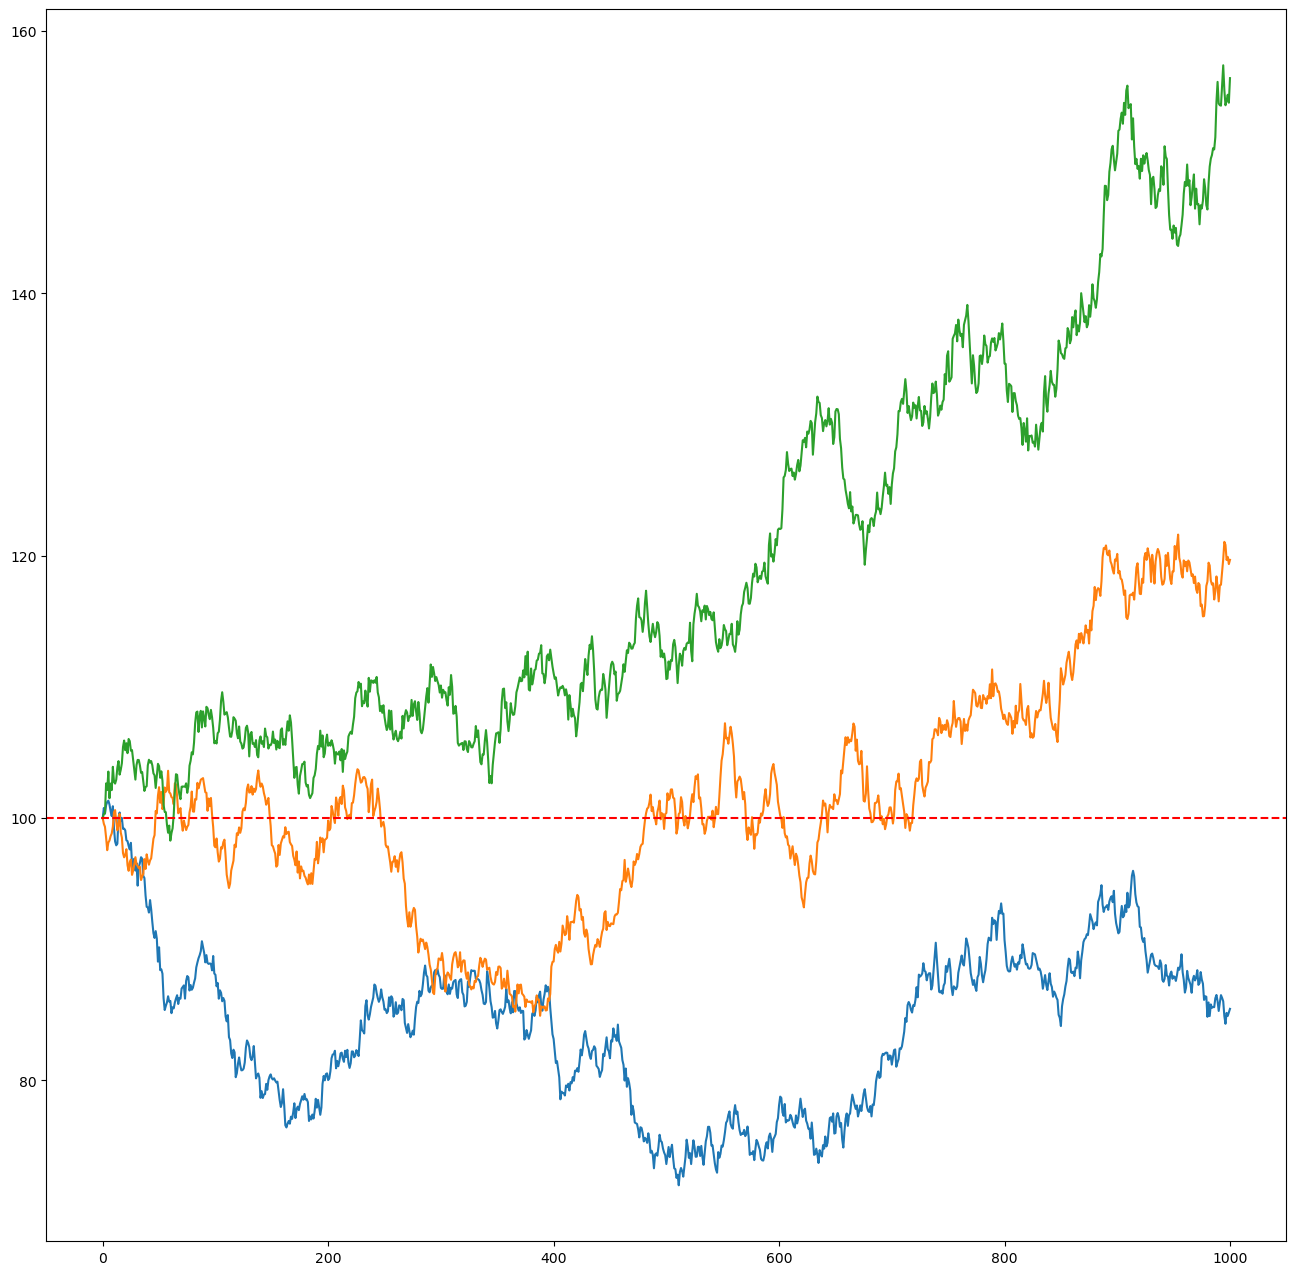

In [153]:
paths = S_euler(100, 0.25, 0.07, 1, 3, 1000)

fig, ax = subplots(figsize = (16, 16))
for i in range(len(paths)): # just plotting everything
    ax.plot(paths[i])
# ye looks good
ax.axhline(100, c = 'r', ls = '--')

In [169]:
# at each point we want to see if we want to continue or not
def amer_option(S0, sigma, r, T, K, step, N, M):
    paths = np.array(S_euler(S0, sigma, r, T, N, M))
    dt = T / M
    final_payoffs = np.maximum(K - paths[:,-1], 0)

    # backwards induction
    for t in range(M-1, step-1, -1):
        S_t = paths[:, t] # current price
        ITM = np.where(S_t < K)[0] # ITM has indexes of all that stock is less than K, 0 just extracts indexes

        if len(ITM) == 0: # no paths itm
            continue

        X = S_t[ITM] # prices of stocks itm
        Y = final_payoffs[ITM] * np.e ** (-r * dt) # price at next step cos DISCOUNTED cos rfr

        #quadratic cos higher degrees overfit (i think quadratic arbitrary tho and like a quartic or smthing could work)
        # WE ARE ESTIMATING THE CONTINUATION VALUE FORMULA USING STOCK PRICE
        # WE FIT IT USING STATSMODELS OLS, can also look more deeply into results if u do summarize(results)
        X_quadratic = np.column_stack((np.ones(len(X)), X, X ** 2)) # 1st column 1s, 2nd column X, 3rd column X^2
        model = sm.OLS(Y, X_quadratic) # instantiating and fitting model, BASICALLY A LINEAR REGRESSION (but quadratic)
        results = model.fit() # fititng model, this bit just basically getting results
        cont_val = results.predict(X_quadratic) # predicting using polynomial regression

        exercise = K - X

        final_payoffs[ITM] = np.where(exercise > cont_val, exercise, final_payoffs[ITM] * np.e ** (-r * dt))

    price = np.mean(final_payoffs) * np.e ** (-r * dt)
    return price  

In [175]:
amer_option(100, 0.25, 0.07, 1, 100, 900, 1000, 1000)

7.173145968259389